In [1]:
from time import time
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.root_path import config_path
from src.visualization.interactive import *

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-03-11 145021.log


In [2]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'stim_type': 'permutations'}

file_dict = dict(
    dprime=pl.Path(config['paths']['analysis_cache']) / f'220224_ctx_mod_metric_DF_cluster_mass',
    mean_difference=pl.Path(config['paths']['analysis_cache']) / f'220301_ctx_mod_metric_DF_mean_diff_cluster_mass',
    t_statistic=pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
)
### same example cell as in figure 1 ###
prb_idx = 3 - 1  # selected probe. the -1 is to acount for 0 not being used
ctx_pair = [0, 1]  # pair of contexts to compare and exemplify d'
cellid = 'ARM021b-36-8'


def format_dataframe(DF):
    ff_analylis = DF.analysis.isin(['SC'])
    ff_badsites = ~DF.siteid.isin(['TNC010a'])
    mask = ff_analylis & ff_badsites

    if 'cluster_threshold' not in DF.columns:
        DF['cluster_threshold'] = 0

    good_cols = ['source', 'mult_comp_corr', 'cluster_threshold', 'region', 'siteid', 'cellid', 'context_pair',
                 'probe', 'metric', 'value']
    filtered = DF.loc[mask, good_cols]

    filtered['probe'] = [int(p) for p in filtered['probe']]
    filtered['context_pair'] = [f"{int(cp.split('_')[0]):02d}_{int(cp.split('_')[1]):02d}"
                                for cp in filtered['context_pair']]

    # rename metrics and analysis for ease of ploting
    filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'duration',
                                                     'significant_abs_sum': "amplitude"})

    filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
    filtered = filtered.drop(columns=['cellid'])
    filtered.rename(columns={'siteid': 'site'}, inplace=True)

    filtered['value'] = filtered['value'].fillna(value=0)

    # permutation related preprocesing.
    # creates a new column relating probe with  context pairs
    ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
    prb = np.asarray(filtered.probe, dtype=int)

    silence = ctx == 0
    same = ctx == prb[:, None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)
    name_arr[silence] = 'silence'
    name_arr[same] = 'same'
    name_arr[different] = 'diff'
    comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

    # swaps clasification names to not have repetitions i.e. diff_same == same_diff
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
    comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
    comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

    filtered['trans_pair'] = comp_name_arr

    # column specifying number of different sounds used
    nstim = filtered.groupby(['id']).agg(stim_count=('probe', lambda x: x.nunique()))
    filtered = pd.merge(filtered, nstim, on='id')

    return filtered


# longDF = list()
# for diff_metric, file in file_dict.items():
#     df = format_dataframe(jl.load(file))
#     df['diff_metric'] = diff_metric
#     longDF.append(df)
#
#
# longDF = pd.concat(longDF, axis=0, ignore_index=True)

longDF = jl.load(file_dict['t_statistic'])
longDF['diff_metric'] = 't_statistic'

print(f'columns: {longDF.columns}')
longDF.head()

columns: Index(['id', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'analysis', 'site', 'region', 'source', 'cluster_threshold',
       'stim_count', 'trans_pair', 'diff_metric'],
      dtype='object')


,id,context_pair,probe,value,metric,mult_comp_corr,analysis,site,region,source,cluster_threshold,stim_count,trans_pair,diff_metric
0,ARM025a-05-2,00_01,1,0.0,mass_center,bf_cp,SC,ARM025a,PEG,real,0.05,4,same_silence,t_statistic
1,ARM025a-11-2,00_01,1,0.0,mass_center,bf_cp,SC,ARM025a,PEG,real,0.05,4,same_silence,t_statistic
2,ARM025a-12-3,00_01,1,225.792291,mass_center,bf_cp,SC,ARM025a,PEG,real,0.05,4,same_silence,t_statistic
3,ARM025a-12-4,00_01,1,0.0,mass_center,bf_cp,SC,ARM025a,PEG,real,0.05,4,same_silence,t_statistic
4,ARM025a-14-1,00_01,1,0.0,mass_center,bf_cp,SC,ARM025a,PEG,real,0.05,4,same_silence,t_statistic


# Differences between mutiple comparisons
in the table we see the percentage of context-pair * probe * neuron that are significantly modulate
considering different multiple bonferrony corrections for context and probe (bf_cp), context probe time (bf_cpt),
neuron context probe time (bf_ncpt), just time (bf_t), old 3 consecutive time bins, and with different
cluster thresholds for the cluster mass analysis.

In [3]:
pivoted = longDF.pivot_table(index=['source', 'diff_metric', 'mult_comp_corr', 'cluster_threshold',
                                    'region', 'stim_count',
                                    'context_pair', 'probe',
                                    'id', 'site'],
                             columns=['metric'], values='value', aggfunc='first')

In [4]:

counts = pivoted.groupby(['source', 'diff_metric', 'mult_comp_corr', 'cluster_threshold']
                         ).agg(signif_percent=('mass_center', lambda x: (x > 0).sum() / x.size * 100),
                               signif_count=('mass_center', lambda x: (x > 0).sum()))
counts

signif_percent  \
source      diff_metric mult_comp_corr cluster_threshold                   
real        t_statistic bf_cp          0.01                     6.908754   
                                       0.05                     7.873437   
                        bf_ncp         0.01                     4.338326   
                                       0.05                     4.881819   
                        none           0.01                    29.771197   
                                       0.05                    34.847465   
shuffled_eg t_statistic bf_cp          0.01                     0.017177   
                                       0.05                     0.018552   
                        bf_ncp         0.01                     0.004123   
                                       0.05                     0.001374   
                        none           0.01                     2.814347   
                                       0.05                     3.256150   

                                                          signif_count  
source      diff_metric mult_comp_corr cluster_threshold                
real        t_statistic bf_cp          0.01                      10055  
                                       0.05                      11459  
                        bf_ncp         0.01                       6314  
                                       0.05                       7105  
                        none           0.01                      43329  
                                       0.05                      50717  
shuffled_eg t_statistic bf_cp          0.01                         25  
                                       0.05                         27  
                        bf_ncp         0.01                          6  
                                       0.05                          2  
                        none           0.01                       4096  
                                       0.05                       4739

## different distributions in context modulation space
scatter of amplitud and duration of contextual modulations calculated for different time series metrics
(dprime, mean difference and  t-statistic) and with different bonferroni corrections


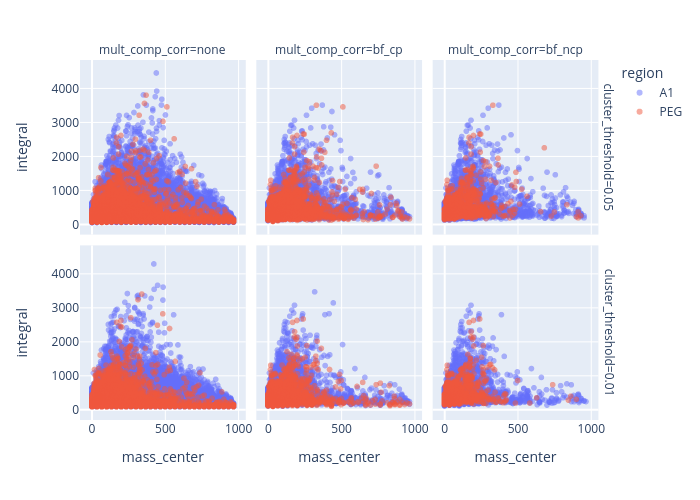

In [5]:
idx = pd.IndexSlice
mult_comps = ['none', 'bf_cp', 'bf_ncp']
clust_threshs = [0.05, 0.01]
toplot = pivoted.loc[idx['real', :, mult_comps, clust_threshs], :].query('integral > 0').reset_index()

scat = px.scatter(data_frame=toplot, x='mass_center', y='integral',
                  facet_col='mult_comp_corr', facet_row='cluster_threshold',
                  hover_data=['id', 'context_pair', 'probe'], color='region',
                  opacity=0.5)

_ = scat.update_layout(showlegend=True)
# _ = scat.update_yaxes(matches=None) # uncoment if dissimilar Y units

# scat.show() # interactive, big file, wont push to github

# png to not fill so much space
img_bytes = scat.to_image(format="png")
Image(img_bytes)

## use alternate duration metric: last significant bin

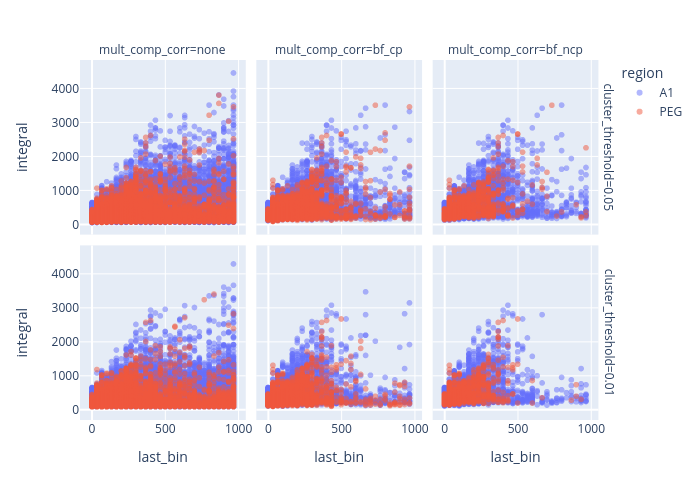

In [6]:
idx = pd.IndexSlice
mult_comps = ['none', 'bf_cp', 'bf_ncp']
clust_threshs = [0.05, 0.01]
toplot = pivoted.loc[idx['real', :, mult_comps, clust_threshs], :].query('integral > 0').reset_index()

scat = px.scatter(data_frame=toplot, x='last_bin', y='integral',
                  facet_col='mult_comp_corr', facet_row='cluster_threshold',
                  hover_data=['id', 'context_pair', 'probe'], color='region',
                  opacity=0.5)

_ = scat.update_layout(showlegend=True)
# _ = scat.update_yaxes(matches=None) # uncoment if dissimilar Y units

# scat.show() # interactive, big file, wont push to github

# png to not fill so much space
img_bytes = scat.to_image(format="png")
Image(img_bytes)

## just the one selected combination of cluster threshold and bf correction
neuronse can be picked from this interactive plot

In [7]:
inferno = px.colors.sequential.Inferno
len(inferno)

10

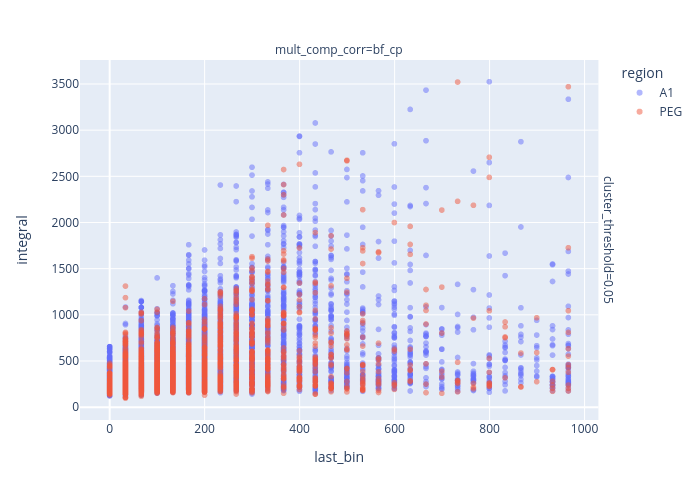

In [8]:
idx = pd.IndexSlice
toplot = pivoted.loc[idx['real', :, 'bf_cp', 0.05], :].query('integral > 0').reset_index()

scat = px.scatter(data_frame=toplot, x='last_bin', y='integral',
                  facet_col='mult_comp_corr', facet_row='cluster_threshold',
                  hover_data=['id', 'context_pair', 'probe'], color='region',
                  opacity=0.5)

img_bytes = scat.to_image(format="png")
Image(img_bytes)


## heatmaps with log color map
perhaps much easier to read

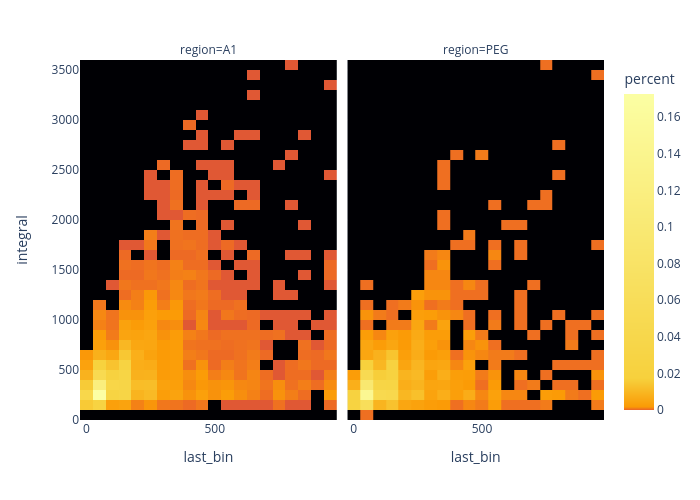

In [9]:
# trick to define a log colorscale
inferno = px.colors.sequential.Inferno
colorscale = list()
for n, color in enumerate(inferno):
    if n != 0:
        n = 1 / (10**(len(inferno)-n-1))
    colorscale.append([n, color])

toplot = pivoted.loc[idx['real', :, 'bf_cp', 0.05], :].query('integral > 0').reset_index()

hmap = px.density_heatmap(data_frame=toplot, x='last_bin', y='integral',
                          facet_col='region',
                          histnorm='probability',
                          hover_data=['id', 'context_pair', 'probe'])

hmap.update_layout(showlegend=True,
                   coloraxis= {'colorbar': {'title': {'text': 'percent'}},
                               'colorscale': colorscale},)


img_bytes = hmap.to_image(format="png")
Image(img_bytes)
# hmap.show()

# example neuron from the previous plot.
this neuron appears on the lowe threshold (permisive) but not high threshold cluster analysis

correcting for 550 multiple comparisons, alpha: 0.05 -> 9.090909090909092e-05
using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 3770.93 d'*ms
center of mass: 431.97 ms
last bin: 966.67 ms


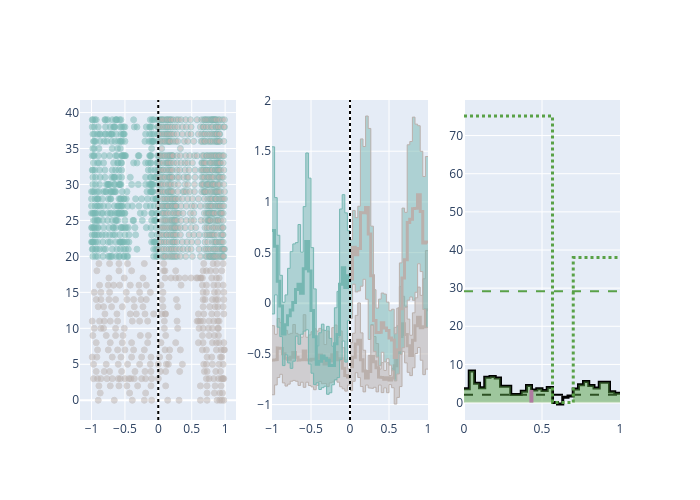

In [10]:
# cellid, contexts, probes = 'ARM021b-36-8', (0, 1), 3  # paper example
cellid, contexts, probes = 'TNC008a-05-1', (0, 3), 6

fig = make_subplots(1, 3)

raster = plot_raw_pair(cellid, contexts, probes, type='raster')
psth = plot_raw_pair(cellid, contexts, probes, type='psth')
quant = plot_time_ser_quant(cellid, contexts, probes, source='real',
                            multiple_comparisons_axis=[1, 2], consecutive=0, cluster_threshold=0.05,
                            fn_name='t_statistic', meta=meta)

_ = fig.add_traces(raster['data'], rows=[1] * len(raster['data']), cols=[1] * len(raster['data']))
_ = fig.add_traces(psth['data'], rows=[1] * len(psth['data']), cols=[2] * len(psth['data']))
_ = fig.add_traces(quant['data'], rows=[1] * len(quant['data']), cols=[3] * len(quant['data']))

_ = fig.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=1)
_ = fig.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=2)

_ = fig.update_layout(showlegend=False)

# fig.show()
subplots_bytes = fig.to_image(format="png")
Image(subplots_bytes)

### find example clearly divergent between thresholds

In [11]:
idx = pd.IndexSlice
clust_threshs = [0.05, 0.01]
filt = pivoted.loc[idx['real', 't_statistic', 'bf_cp', clust_threshs], :].reset_index()
piv2 = filt.pivot_table(index=['context_pair', 'probe', 'id'], columns=['cluster_threshold'], values='integral',
                        aggfunc='first')
piv2['diff'] = piv2[0.05] - piv2[0.01]
piv2.sort_values(['diff'], ascending=[False], inplace=True)
piv2.head(5)

,,cluster_threshold,0.01,0.05,diff
context_pair,probe,id,,,
03_09,3,TNC013a-22-2,0.000000,2384.165435,2384.165435
00_10,6,TNC016a-30-2,0.000000,1951.418333,1951.418333
01_04,3,CRD012b-13-1,1024.819134,2706.430553,1681.611419
00_07,6,TNC016a-30-2,0.000000,1636.991833,1636.991833
01_06,6,TNC014a-40-4,1016.213471,2649.021768,1632.808297


In [29]:
# pick and example from the table above.
eg = piv2.iloc[1,:]
cellid = eg.name[2]
contexts = tuple(int(cp) for cp in eg.name[0].split('_'))
probes = eg.name[1]

correcting for 550 multiple comparisons, alpha: 0.05 -> 9.090909090909092e-05
using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 1951.42 d'*ms
center of mass: 564.76 ms
last bin: 866.67 ms
correcting for 550 multiple comparisons, alpha: 0.05 -> 9.090909090909092e-05
using t-score threshold for sample-alpha 0.01 -> t = 2.7115576019130625
integral: 1165.97 d'*ms
center of mass: 583.36 ms
last bin: 766.67 ms


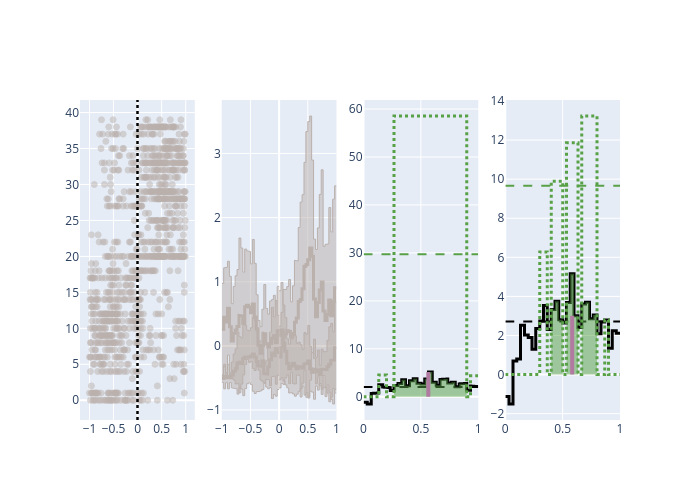

In [30]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'stim_type': 'permutations'}

psth = plot_raw_pair(cellid, contexts, probes, type='psth')

raster = plot_raw_pair(cellid, contexts, probes, type='raster')

dprm_th_lo = plot_time_ser_quant(cellid, contexts, probes, source='real',
                                 multiple_comparisons_axis=[1, 2], consecutive=0, cluster_threshold=0.05,
                                 fn_name='t_statistic',
                                 meta=meta)

dprm_th_hi = plot_time_ser_quant(cellid, contexts, probes, source='real',
                                 multiple_comparisons_axis=[1, 2], consecutive=0, cluster_threshold=0.01,
                                 fn_name='t_statistic',
                                 meta=meta)
subplots = make_subplots(1, 4)
subplots.update_layout(showlegend=False)

_ = subplots.add_traces(raster['data'], rows=[1] * len(raster['data']), cols=[1] * len(raster['data']))
_ = subplots.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=1)

_ = subplots.add_traces(psth['data'], rows=[1] * len(psth['data']), cols=[2] * len(psth['data']))
_ = subplots.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=1)

_ = subplots.add_traces(dprm_th_lo['data'], rows=[1] * len(dprm_th_lo['data']), cols=[3] * len(dprm_th_lo['data']))
_ = subplots.add_traces(dprm_th_hi['data'], rows=[1] * len(dprm_th_hi['data']), cols=[4] * len(dprm_th_hi['data']))

# subplots.show()
subplots_bytes = subplots.to_image(format="png")
Image(subplots_bytes)

### same example as before, just ussing 11000 shuffles

correcting for 550 multiple comparisons, alpha: 0.05 -> 9.090909090909092e-05
using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 1951.42 d'*ms
center of mass: 564.76 ms
last bin: 866.67 ms
correcting for 550 multiple comparisons, alpha: 0.05 -> 9.090909090909092e-05
using t-score threshold for sample-alpha 0.01 -> t = 2.7115576019130625
integral: 0.00 d'*ms
center of mass: 0.00 ms
last bin: 0.00 ms


/auto/users/mateo/code/context_probe_analysis/src/visualization/interactive.py:204: RuntimeWarning:

invalid value encountered in double_scalars



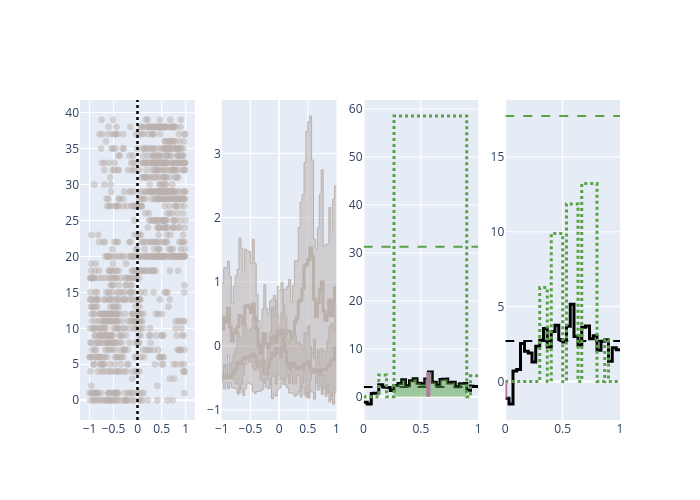

In [31]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 11000,
        'zscore': True,
        'stim_type': 'permutations'}

psth = plot_raw_pair(cellid, contexts, probes, type='psth')

raster = plot_raw_pair(cellid, contexts, probes, type='raster')

dprm_th_lo = plot_time_ser_quant(cellid, contexts, probes, source='real',
                                 multiple_comparisons_axis=[1, 2], consecutive=0, cluster_threshold=0.05,
                                 fn_name='big_shuff',
                                 meta=meta)

dprm_th_hi = plot_time_ser_quant(cellid, contexts, probes, source='real',
                                 multiple_comparisons_axis=[1, 2], consecutive=0, cluster_threshold=0.01,
                                 fn_name='big_shuff',
                                 meta=meta)
subplots = make_subplots(1, 4)
subplots.update_layout(showlegend=False)

_ = subplots.add_traces(raster['data'], rows=[1] * len(raster['data']), cols=[1] * len(raster['data']))
_ = subplots.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=1)

_ = subplots.add_traces(psth['data'], rows=[1] * len(psth['data']), cols=[2] * len(psth['data']))
_ = subplots.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1, row=1, col=1)

_ = subplots.add_traces(dprm_th_lo['data'], rows=[1] * len(dprm_th_lo['data']), cols=[3] * len(dprm_th_lo['data']))
_ = subplots.add_traces(dprm_th_hi['data'], rows=[1] * len(dprm_th_hi['data']), cols=[4] * len(dprm_th_hi['data']))

# subplots.show()
subplots_bytes = subplots.to_image(format="png")
Image(subplots_bytes)